# Homework 2

In [4]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import numpy as np
from collections import Counter, defaultdict
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from nltk.corpus import stopwords

# nltk.download('wordnet')
# nltk.download('stopwords')

In [5]:
austen = nltk.corpus.gutenberg.words('austen-sense.txt')

In [83]:
def heatmap_by_topic_doc(z_m_n, K, D, vmin, vmax):
## Generate a heatmap where x-axis is Document, y-axis is Topic, and value is frequency of assigned words
    distn = np.zeros((D, K))
    for i in range(len(z_m_n)):
        cnt = Counter()
        for j in range(len(z_m_n[i])):
            cnt[z_m_n[i][j]] += 1

        doc_len = len(z_m_n[i])
        for k in range(K):
            distn[i,k] = cnt.get(k,0) / doc_len

    sns.heatmap(distn.T,cmap='Greys', vmin=vmin, vmax=vmax)
    plt.xlabel('Document')
    plt.ylabel('Topic')
    plt.show()

# Using Jane Austen's **Sense**
## [1] Preprocessing
* Remove all non-words
* Remove all stop words
* Lowercase and lemmatize
* Remove words with <=10 occurrences

In [7]:
lemmatizer = WordNetLemmatizer()
austen = [word for word in austen if word.isalpha()]

austen = [word.lower() for word in austen]
austen = [word for word in austen if not word in stopwords.words('english')] # remove stop words
austen = [lemmatizer.lemmatize(word) for word in austen]

austen_list = austen

### [1.1] Word-to-Int mapping

In [8]:
freqs = Counter()
for token in austen_list:
    freqs[token] += 1                                 # freqs is dict(), i.e. freqs[word] = count
freqs = freqs.most_common()                   # now freqs is tuple of (word, count)
words_to_drop = [k for k,v in freqs if v<10]

word2int = {freqs[i][0]:i for i in range(len(freqs)) if not freqs[i][0] in words_to_drop}  # mapping is dict of freqs[word]=r where r=rank
int2word = {v:k for k,v in word2int.items()}

austen_list = [word for word in austen_list if not word in words_to_drop]

freqs = Counter()
for token in austen_list:
    freqs[token] += 1
freqs = freqs.most_common()

### [1.2] Split the corpus into documents on the word "chapter"

In [9]:
docs = []
start = 0
i = 0
while i < len(austen_list):
    if austen_list[i] == 'chapter':
        docs.append(austen_list[start:i-1])
        start = i + 1
    i += 1
    
docs = docs[1:]                  # the first doc is very short, throw it out
N_W = sum(len(doc) for doc in docs)
N_W_unique = len(set(austen_list))
N_D = len(docs)
print('Total number of tokens: ' + str(N_W))
print('Number of unique tokens: ' + str(N_W_unique))
print('Number of documents: ' + str(N_D))

Total number of tokens: 41212
Number of unique tokens: 1060
Number of documents: 49


### [1.3] Collapsed Gibbs Sampling
In this section, we try 3 different hyperparameter settings, denoted in sections by
* [1.31] ($\alpha$=$\beta$=0.1, $K$=10)
   * [1.31a] Initialization 
   * [1.31b] Iteration
* [1.32] ($\alpha$=$\beta$=0.01, $K$=10)
   * [1.32a] Initialization 
   * [1.32b] Iteration
* [1.33] ($\alpha$=$\beta$=0.1, $K$=50)
   * [1.33a] Initialization
   * [1.33b] Iteration

In [66]:
K = 10
V = len(set(austen_list))
D = len(docs)
alpha = 0.1
beta = alpha

# for printing a number of words from randomly chosen topics (to compare before and after)
topic_groups_to_print = np.random.randint(0, K, 2)
number_words_to_print = 10

#### [1.31a] Initialization ($\alpha$=$\beta$=0.1, $K$=10)

Initialized heatmap


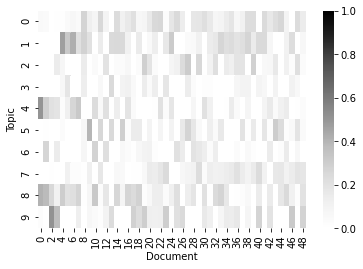

Most common words from topic group #3
said, great, come, day, see, dear, miss, say, year, might, 

Most common words from topic group #6
marianne, said, colonel, know, letter, may, sir, time, away, indeed, 



In [8]:
z_d_ld = [] # word-topic assignment (size = # documents x len(document i)), topic<-z
n_d_k = np.zeros((D, K)) + alpha # word counts by document and topic
n_k_v = np.zeros((K, V)) + beta # word counts by topic and word2int
n_k = np.zeros(K) + V*beta # word counts by topic
for i_doc, doc in enumerate(docs):
    z_n = []
    for word in doc:
        p_z = n_k_v[:, word2int[word]] * n_d_k[i_doc] / n_k     # probability dist'n of topics
        z = np.random.multinomial(1, p_z / p_z.sum()).argmax()  # randomly sampled topic
        
        # increment this topic
        z_n.append(z)
        n_d_k[i_doc, z] += 1
        n_k_v[z, word2int[word]] += 1
        n_k[z] += 1
    z_d_ld.append(np.array(z_n))
    
print('Initialized heatmap')
heatmap_by_topic_doc(z_d_ld, K, D, 0, 1)

for group_id in topic_groups_to_print:
    print('Most common words from topic group #' + str(group_id))
    ids = (-n_k_v[group_id, :]).argsort()[:number_words_to_print]
    for idd in ids:
        print(int2word[idd],end=', ')
    print('\n')

#### [1.31b] Iteration ($\alpha$=$\beta$=0.1, $K$=10)

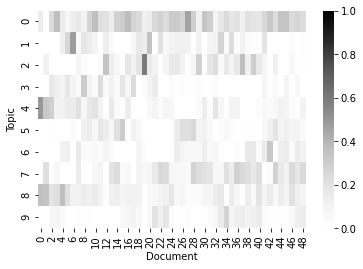

Most common words from topic group #3
said, know, replied, margaret, think, john, walk, barton, park, taste, 

Most common words from topic group #6
mr, colonel, jennings, brandon, soon, friend, barton, day, hope, palmer, 



In [9]:
num_iter = 100
for i in range(num_iter):
    for i_doc, doc in enumerate(docs):
        for i_word, word in enumerate(doc):
            z = z_d_ld[i_doc][i_word]
            # decrement this topic
            n_d_k[i_doc, z] -= 1
            n_k_v[z, word2int[word]] -= 1
            n_k[z] -= 1
            
            # draw new topic
            p_z = n_d_k[i_doc] * n_k_v[:, word2int[word]] / n_k
            new_z = np.random.multinomial(1, p_z / p_z.sum()).argmax()
            
            # increment new topic
            z_d_ld[i_doc][i_word] = new_z
            n_d_k[i_doc, new_z] += 1
            n_k_v[new_z, word2int[word]] += 1
            n_k[new_z] += 1
    print('Iteration #', i)
    clear_output(wait=True)
    
heatmap_by_topic_doc(z_d_ld, K, D, 0, 1)
for group_id in topic_groups_to_print:
    print('Most common words from topic group #' + str(group_id))
    ids = (-n_k_v[group_id, :]).argsort()[:number_words_to_print]
    for idd in ids:
        print(int2word[idd],end=', ')
    print('\n')

#### [1.32a] Initialization ($\alpha$=$\beta$=0.01, $K$=10)

Initialized heatmap


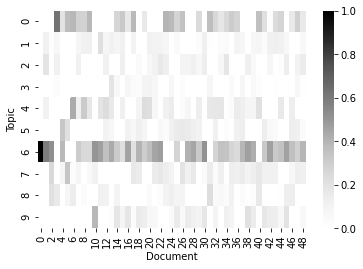

Most common words from topic group #6
mr, elinor, could, would, marianne, every, sister, one, must, dashwood, 

Most common words from topic group #0
elinor, marianne, would, could, every, well, edward, one, much, sister, 



In [10]:
K = 10
V = len(set(austen_list))
D = len(docs)
alpha = 0.01
beta = alpha

# for printing a number of words from randomly chosen topics (to compare before and after)
topic_groups_to_print = np.random.randint(0, K, 2)
number_words_to_print = 10

z_d_ld = [] # word-topic assignment (size = # documents x len(document i)), topic<-z
n_d_k = np.zeros((D, K)) + alpha # word counts by document and topic
n_k_v = np.zeros((K, V)) + beta # word counts by topic and word2int
n_k = np.zeros(K) + V*beta # word counts by topic
for i_doc, doc in enumerate(docs):
    z_n = []
    for word in doc:
        p_z = n_k_v[:, word2int[word]] * n_d_k[i_doc] / n_k     # probability dist'n of topics
        z = np.random.multinomial(1, p_z / p_z.sum()).argmax()  # randomly sampled topic
        
        # increment this topic
        z_n.append(z)
        n_d_k[i_doc, z] += 1
        n_k_v[z, word2int[word]] += 1
        n_k[z] += 1
    z_d_ld.append(np.array(z_n))
    
print('Initialized heatmap')
heatmap_by_topic_doc(z_d_ld, K, D), 0, 1

for group_id in topic_groups_to_print:
    print('Most common words from topic group #' + str(group_id))
    ids = (-n_k_v[group_id, :]).argsort()[:number_words_to_print]
    for idd in ids:
        print(int2word[idd],end=', ')
    print('\n')

#### [1.32b] Iteration ($\alpha$=$\beta$=0.01, $K$=10)

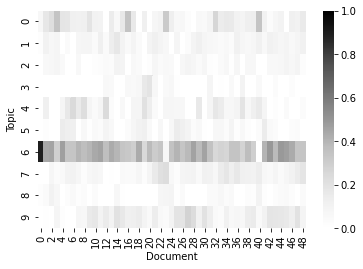

Most common words from topic group #6
marianne, mr, could, would, every, sister, one, time, elinor, must, 

Most common words from topic group #0
elinor, would, said, much, well, make, could, edward, great, one, 



In [11]:
num_iter = 100
for i in range(num_iter):
    for i_doc, doc in enumerate(docs):
        for i_word, word in enumerate(doc):
            z = z_d_ld[i_doc][i_word]
            # decrement this topic
            n_d_k[i_doc, z] -= 1
            n_k_v[z, word2int[word]] -= 1
            n_k[z] -= 1
            
            # draw new topic
            p_z = n_d_k[i_doc] * n_k_v[:, word2int[word]] / n_k
            new_z = np.random.multinomial(1, p_z / p_z.sum()).argmax()
            
            # increment new topic
            z_d_ld[i_doc][i_word] = new_z
            n_d_k[i_doc, new_z] += 1
            n_k_v[new_z, word2int[word]] += 1
            n_k[new_z] += 1
    print('Iteration #', i)
    clear_output(wait=True)
    
heatmap_by_topic_doc(z_d_ld, K, D)
for group_id in topic_groups_to_print:
    print('Most common words from topic group #' + str(group_id))
    ids = (-n_k_v[group_id, :]).argsort()[:number_words_to_print]
    for idd in ids:
        print(int2word[idd],end=', ')
    print('\n')

#### [1.33a] Initialization ($\alpha$=$\beta$=0.1, $K$=50)

Initialized heatmap


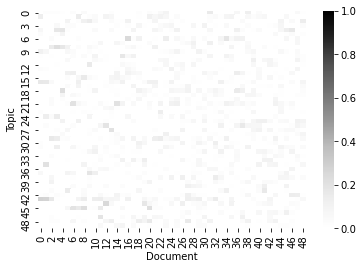

Most common words from topic group #25
jennings, edward, soon, last, would, think, suppose, must, upon, entirely, 

Most common words from topic group #22
place, return, reason, going, willoughby, often, carriage, many, matter, quite, 



In [12]:
K = 50
V = len(set(austen_list))
D = len(docs)
alpha = 0.1
beta = alpha

# for printing a number of words from randomly chosen topics (to compare before and after)
topic_groups_to_print = np.random.randint(0, K, 2)
number_words_to_print = 10

z_d_ld = [] # word-topic assignment (size = # documents x len(document i)), topic<-z
n_d_k = np.zeros((D, K)) + alpha # word counts by document and topic
n_k_v = np.zeros((K, V)) + beta # word counts by topic and word2int
n_k = np.zeros(K) + V*beta # word counts by topic
for i_doc, doc in enumerate(docs):
    z_n = []
    for word in doc:
        p_z = n_k_v[:, word2int[word]] * n_d_k[i_doc] / n_k     # probability dist'n of topics
        z = np.random.multinomial(1, p_z / p_z.sum()).argmax()  # randomly sampled topic
        
        # increment this topic
        z_n.append(z)
        n_d_k[i_doc, z] += 1
        n_k_v[z, word2int[word]] += 1
        n_k[z] += 1
    z_d_ld.append(np.array(z_n))
    
print('Initialized heatmap')
heatmap_by_topic_doc(z_d_ld, K, D, 0, 1)

for group_id in topic_groups_to_print:
    print('Most common words from topic group #' + str(group_id))
    ids = (-n_k_v[group_id, :]).argsort()[:number_words_to_print]
    for idd in ids:
        print(int2word[idd],end=', ')
    print('\n')

#### [1.33b] Iteration ($\alpha$=$\beta$=0.1, $K$=50)

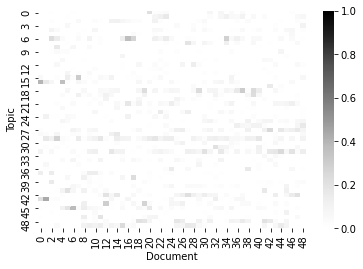

Most common words from topic group #25
would, friend, though, barton, hour, might, within, every, week, entirely, 

Most common words from topic group #22
passed, invitation, help, part, perfectly, time, broken, honour, future, explained, 



In [13]:
num_iter = 100
for i in range(num_iter):
    for i_doc, doc in enumerate(docs):
        for i_word, word in enumerate(doc):
            z = z_d_ld[i_doc][i_word]
            # decrement this topic
            n_d_k[i_doc, z] -= 1
            n_k_v[z, word2int[word]] -= 1
            n_k[z] -= 1
            
            # draw new topic
            p_z = n_d_k[i_doc] * n_k_v[:, word2int[word]] / n_k
            new_z = np.random.multinomial(1, p_z / p_z.sum()).argmax()
            
            # increment new topic
            z_d_ld[i_doc][i_word] = new_z
            n_d_k[i_doc, new_z] += 1
            n_k_v[new_z, word2int[word]] += 1
            n_k[new_z] += 1
    print('Iteration #', i)
    clear_output(wait=True)
    
heatmap_by_topic_doc(z_d_ld, K, D, 0, 1)
for group_id in topic_groups_to_print:
    print('Most common words from topic group #' + str(group_id))
    ids = (-n_k_v[group_id, :]).argsort()[:number_words_to_print]
    for idd in ids:
        print(int2word[idd],end=', ')
    print('\n')

### [1.34] Discussion
We have not read the book. It is a fictional novel and from what we can tell, the language doesn't differ from chapter to chapter much outside of locations which are sparsely mentioned.

For $K=10$, we are curious why the topics seem to overlap so much. We note that parts of speech seem to be relatively consistent within groups, however. $K=50$ seems to make more intuitive sense, but this kind of analysis is very subjective.

Overall it is hard to say much about the validity of the topics given our lack of context about the text.

## [1.4] Hidden Markov Topic Model
In this approach we consider the state changes, i.e. $z_{d,t-1}$ and $z_{d,t+1}$ are considered when evaluating the topic assignment $z_{d,t}$.

In [67]:
K = 50
V = len(set(austen_list))
D = len(docs)
alpha = 0.1
beta = alpha
# gamma = 1
delta = 1
rho = 1

### [1.41] Initialization

In [88]:
n_d_k_k = np.zeros((D, K, K)) # counts of transition in document from one topic to another
s_k = np.zeros(K) # number of documents that start with each topic

z_d_ld = [] # word-topic assignment (size = # documents x len(document i)), topic<-z
n_d_k = np.zeros((D, K)) + alpha # word counts by document and topic
n_k_v = np.zeros((K, V)) + beta # word counts by topic and word2int
n_k = np.zeros(K) + V*beta # word counts by topic
for i_doc, doc in enumerate(docs):
    z_n = []
    for word in doc:
        p_z = n_k_v[:, word2int[word]] * n_d_k[i_doc] / n_k     # probability dist'n of topics
        z = np.random.multinomial(1, p_z / p_z.sum()).argmax()  # randomly sampled topic
        
        # increment this topic
        z_n.append(z)
        n_d_k[i_doc, z] += 1
        n_k_v[z, word2int[word]] += 1
        n_k[z] += 1
    z_d_ld.append(np.array(z_n))
    
for i in range(len(z_d_ld)):
    s_k[z_d_ld[i][0]] += 1
    for j in range(1, len(z_d_ld[i])):
        n_d_k_k[i, z_d_ld[i][j-1], z_d_ld[i][j]] += 1

### [1.42] Iteration

In [89]:
num_iter = 100
for i in range(num_iter):
    for i_doc, doc in enumerate(docs):
        for i_word, word in enumerate(doc):
            z_this = z_d_ld[i_doc][i_word]        # current word's topic
            n_d_k[i_doc, z_this] -= 1
            n_k_v[z_this, word2int[word]] -= 1
            n = sum(n_d_k)
            if i_word == 0:                                 # this is the first word in the doc
                i_next = i_word + 1
                z_next = z_d_ld[i_doc][i_next]
                n_d_k_k[i_doc, z_this, z_next] -= 1
                
                numerator = (beta+n_k_v[:, word2int[word]]) * (alpha+n_d_k_k[i_doc,:,z_next]) * (rho+s_k)
                denominator = (V*beta+n) * (K*alpha*delta+np.sum(n_d_k_k[i_doc], axis=1))
                p = numerator / denominator
                
                if 0 in denominator:
                    print('i_word=0, big')
                    sys.exit(0)
                numerator = (beta+n_k_v[z_next, word2int[word]]) * (alpha+delta+n_d_k_k[i_doc,z_this,z_next]) * (rho+s_k[z_next])
                denominator = (V*beta+n[z_next]) * (K*alpha+delta+np.sum(n_d_k_k[i_doc,:,z_next], axis=0))
                p[z_next] = numerator / denominator
                
                if 0==denominator:
                    print('i_word=0, small')
                    sys.exit(0)
            elif i_word == len(doc) - 1:                    # this is the last word in the doc
                i_last = i_word - 1
                z_last = z_d_ld[i_doc][i_last]
                n_d_k_k[i_doc, z_last, z_this] -= 1
                
                numerator = (beta+n_k_v[:, word2int[word]]) * (alpha+n_d_k_k[i_doc,z_this,:])
                denominator = V*beta+n
                p = numerator / denominator
                
                if 0 in denominator:
                    print('i_word=max, big')
                    sys.exit(0)
                numerator = (beta+n_k_v[z_this, word2int[word]]) * (alpha+delta+n_d_k_k[i_doc, z_last, z_this])
                denominator = V*beta+n[z_last]
                p[z_last] = numerator / denominator
                
                if 0==denominator:
                    print('i_word=max, small')
                    sys.exit(0)
            else:
                i_next = i_word + 1
                i_last = i_word - 1
                z_next = z_d_ld[i_doc][i_next]
                z_last = z_d_ld[i_doc][i_last]
                n_d_k_k[i_doc, z_last, z_this] -= 1
                n_d_k_k[i_doc, z_this, z_next] -= 1
                
                numerator = (beta+n_k_v[:, word2int[word]]) * (alpha+n_d_k_k[i_doc, :, z_next]) * (alpha+n_d_k_k[i_doc, z_last, :])
                denominator = (V*beta+n) * (K*alpha+delta+np.sum(n_d_k_k[i_doc],axis=1))
                p = numerator / denominator
                if 0 in denominator:
                    print('i_word=middle, big')
                    sys.exit(0)
                    
                numerator = (beta+n_k_v[z_this, word2int[word]]) * (alpha+n_d_k_k[i_doc, z_last, z_this]) * (alpha+n_d_k_k[i_doc, z_this, z_next])
                denominator = (V*beta+n[z_last]) * (K*alpha+delta+np.sum(n_d_k_k[i_doc, z_last],axis=0))
                p[z_last] = numerator / denominator
                if 0==denominator:
                    print('i_word=middle, z_last')
                    sys.exit(0)
                    
                numerator = (beta+n_k_v[z_last, word2int[word]]) * (alpha+delta+n_d_k_k[i_doc, z_next, z_next]) * (alpha+n_d_k_k[i_doc, z_last, z_next])
                denominator = (V*beta+n[z_next]) * (K*alpha+delta+np.sum(n_d_k_k[i_doc, z_next],axis=0)+1)
                p[z_next] = numerator / denominator
                if 0==denominator:
                    print('i_word=middle, z_next')
                    sys.exit(0)
                    
            z_this = np.random.multinomial(1, p / p.sum()).argmax()
            z_d_ld[i_doc][i_word] = z_this
            if i_word==0:
                n_d_k_k[i_doc, z_this, z_next] += 1
            elif i_word==len(doc)-1:
                n_d_k_k[i_doc, z_last, z_this] += 1
            else:
                n_d_k_k[i_doc, z_last, z_this] += 1
                n_d_k_k[i_doc, z_this, z_next] += 1
                
            n_d_k[i_doc][z_this] += 1
            n_k_v[z_this, word2int[word]] += 1
        s_k[z_this] += 1
    print('Iteration #',i)
    clear_output(wait=True)

Iteration # 99


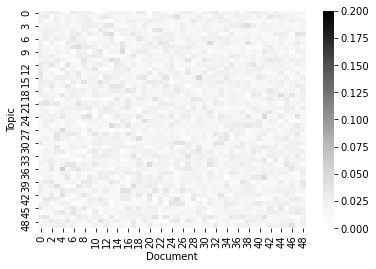

Most common words from topic group #43
could, mr, well, elinor, marianne, much, lady, willoughby, never, ferrars, 

Most common words from topic group #6
mr, would, great, think, miss, could, young, little, john, jennings, 



In [91]:
topic_groups_to_print = np.random.randint(0, K, 2)
number_words_to_print = 10

heatmap_by_topic_doc(z_d_ld, K, D, 0, .2)
for group_id in topic_groups_to_print:
    print('Most common words from topic group #' + str(group_id))
    ids = (-n_k_v[group_id, :]).argsort()[:number_words_to_print]
    for idd in ids:
        print(int2word[idd],end=', ')
    print('\n')

### [1.43] Discussion

DISCUSSION GOES HERE, write about the hyperparameters used and bullshit about how some other params might have been better. we havent read the book, not much differentiation between chapters, etc...